In [89]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

class StopExecution(Exception):
    def _render_traceback_(self):
        return []



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import sys
sys.path.append("..")
import pickle as pkl
import hist
from analyzer.datasets import SampleManager
from analyzer.core import AnalysisResult
import math
import torch
import gpytorch
from torch.masked import masked_tensor, as_masked_tensor
import numpy as np

In [91]:
import matplotlib.pyplot as plt
from analyzer.plotting.plots_1d import drawAs1DHist
from analyzer.plotting.plots_2d import drawAs2DHist, addTitles2D
from analyzer.plotting.plottables import PlotObject
from analyzer.plotting.mplstyles import loadStyles
import analyzer.plotting as plot
loadStyles()

In [92]:
from fitting import regression



In [93]:
res = AnalysisResult.fromFile("../results/data_control.pkl")

In [94]:
sample_manager = SampleManager()
sample_manager.loadSamplesFromDirectory("../datasets")

In [95]:
res.results["CR0b_Data2018"].histograms["h_njet"] 

Hist(
  StrCategory(['CR0b_Data2018'], growth=True, name='dataset', label='Primary dataset'),
  Regular(10, 0, 10, name='nj', label='$n_{j}$'),
  storage=Weight()) # Sum: WeightedSum(value=1.40454e+07, variance=1.40454e+07)

In [96]:
hists = res.getMergedHistograms(sample_manager)

In [120]:
bkg_name="CR0b_Data2018"
complete_hist = hists["ratio_m14_vs_m24"]
narrowed = hist
#orig =  complete_hist[...,hist.loc(1100):hist.loc(2500),hist.loc(400):hist.loc(2000)]
#orig =  complete_hist[...,hist.loc(0):hist.loc(3000),hist.loc(0):hist.loc(1)]
orig =  complete_hist[...,hist.loc(1150):hist.loc(3000),hist.loc(0.4):hist.loc(1)]
#orig = orig / orig.values().max()
#orig =  complete_hist[...,hist.loc(1150):hist.loc(3000),hist.loc(400):hist.loc(3000)]#orig =  complete_hist[...,hist.loc(0):hist.loc(3000),hist.loc(0):hist.loc(3000)]
narrowed = orig
#narrowed = orig[...,::hist.rebin(15),::hist.rebin(12)]
narrowed = orig[...,::hist.rebin(2),::hist.rebin(2)]

qcd_hist = narrowed[bkg_name,...]
orig_qcd_hist = orig[bkg_name,...]

#sig_hist = narrowed["signal_312_1500_900",...]

qcd_hist = narrowed[bkg_name,...] 


In [121]:
torch.set_default_dtype(torch.float64)

In [ ]:
import fitting.high_level as fhl
window = [(1300,1550),(0.55,0.65)]

window_x_start = 1100
window_x_end = 2000
window_x_step = 100

x_iter = map(float,torch.arange(1100, 2000, 250))
x_size_iter = map(float, torch.arange(200,400,100))
y_iter = map(float, torch.arange(0.4,0.7,0.15))
y_size_iter = map(float, torch.arange(0.1,0.3,0.1))

for x,a,y,b in it.product(x_iter, x_size_iter, y_iter, y_size_iter):
    win = [(x,x+a),(y,y+b)]
    path = f"w__{round(win[0][0],3)}_{round(win[0][1],3)}__{round(win[1][0],3)}_{round(win[1][1],3)}".replace(".","p")
    print(f"Now processing {win}")
    fhl.doCompleteRegression(qcd_hist, win, "scan", path)
    plt.close('all')

Optimizing(Loss is -3.655)... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

In [122]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

def addColorbar(ax, vals):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(vals, cax=cax)
    cax.get_yaxis().set_offset_position("left")
    ax.cax = cax

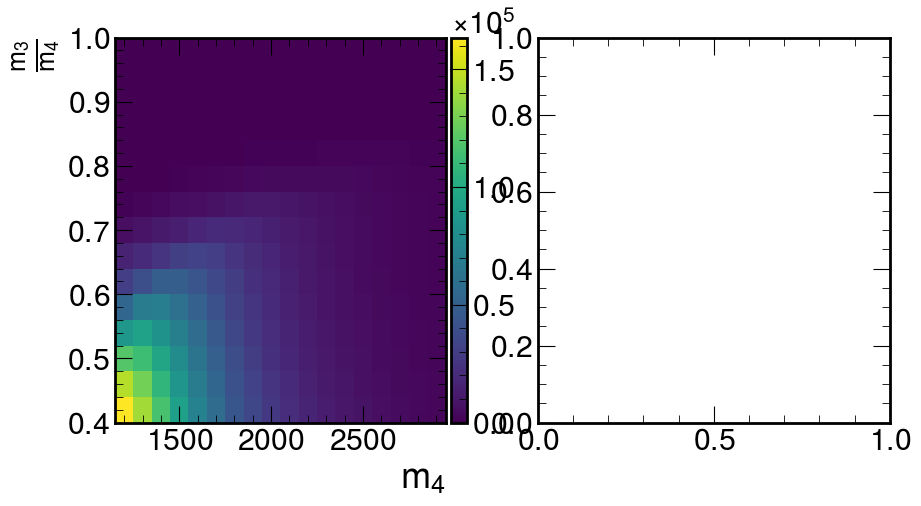

In [140]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
_ = drawAs2DHist(ax[0], PlotObject.fromHist(qcd_hist))
#_ = drawAs2DHist(ax[1], PlotObject.fromHist(sig_hist))

In [209]:
#sig_values = torch.from_numpy(sig_hist.values()).T
#(train, test), centers_mask = regression.preprocessHistograms(qcd_hist, [(0,0),(0.0,0.0)])
window = [(1300,1550),(0.55,0.65)]
#window=None
(raw_train, raw_test), (train, test), centers_mask, values_mask, value_scale = regression.preprocessHistograms(qcd_hist, window, exclude_less=0.0001)


In [199]:
print(raw_train.inputs.shape)
print(raw_test.inputs.shape)

torch.Size([211, 2])
torch.Size([215, 2])


In [200]:
fitting.regression.pointsToGrid(train.inputs, train.outputs, train.edges)

(torch.return_types.histogramdd(
 hist=tensor([[1.0000e+00, 8.8706e-01, 7.3326e-01, 5.3515e-01, 3.2763e-01, 1.8315e-01,
          9.4834e-02, 3.7032e-02, 6.7123e-03, 5.3292e-04, 1.9033e-05, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [8.6116e-01, 7.8606e-01, 6.8602e-01, 5.7469e-01, 4.1498e-01, 2.4131e-01,
          1.1984e-01, 5.2385e-02, 1.4122e-02, 1.2371e-03, 4.4410e-05, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [7.1015e-01, 6.5417e-01, 5.8966e-01, 5.1103e-01, 0.0000e+00, 0.0000e+00,
          1.5111e-01, 6.6425e-02, 2.3303e-02, 2.8993e-03, 4.4410e-05, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.6630e-01, 5.2231e-01, 4.8321e-01, 4.2912e-01, 0.0000e+00, 0.0000e+00,
          1.8516e-01, 8.3916e-02, 3.1582e-02, 6.7059e-03, 1.6495e-04, 6.3443e-06,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [4.4439e-01, 4.1193e-01, 3.8052e-01, 3.4791e-01, 3.0551e-01, 2.5923e-01,
          1.9730e-01, 1.0401e-01, 3.

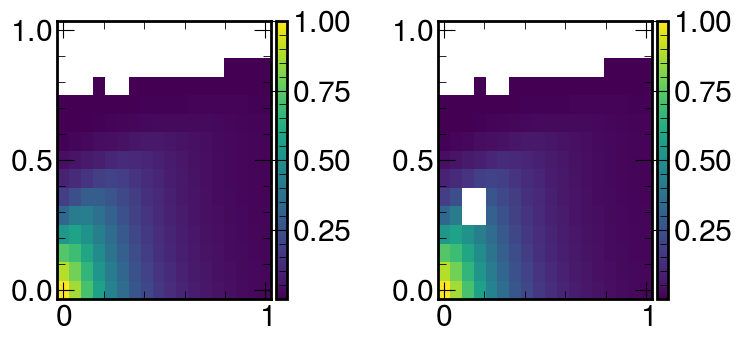

In [201]:
fig,ax = plt.subplots(1,2, figsize=(8,4))
def simpleGrid(ax, edges, inx, iny):
    X,Y = np.meshgrid(*edges)
    z=iny
    #Z=z.reshape(len(edges[1])-1,len(edges[0])-1)
    Z, filled = fitting.regression.pointsToGrid(inx,iny,edges)
    Z=Z.hist.T
    filled=filled.T
    Z = np.ma.masked_where(~filled, Z)
    f = ax.pcolormesh(X,Y,Z)
    addColorbar(ax,f)
    return f

simpleGrid(ax[0],test.edges, test.inputs, test.outputs)
simpleGrid(ax[1],test.edges,  train.inputs, train.outputs)
fig.tight_layout()

In [202]:
from pathlib import Path
import shutil
base_dir = Path("figures")
this_path = "piece_poly_window_1300_1500__0p55_0p65"
figpath = base_dir / this_path
shutil.rmtree(figpath, ignore_errors=True)
figpath.mkdir(parents=True, exist_ok=True)

In [229]:
from fitting import regression
from gpytorch.kernels import ScaleKernel as SK
import fitting.models as models

#model,likelihood = regression.createModel(train, kernel=None)
#model,likelihood = regression.createModel(train, 
#kernel=SK(
#                                              gpytorch.kernels.RBFKernel(ard_num_dims=2) + 
#                                              gpytorch.kernels.LinearKernel(ard_num_dims=2,num_dimensions=2)
#                                          ))
#model,likelihood = regression.createModel(train, kernel=SK(gpytorch.kernels.MaternKernel(ard_num_dims=2)))
#model,likelihood = regression.createModel(train, kernel=SK(gpytorch.kernels.PiecewisePolynomialKernel(ard_num_dims=2)))
#model,likelihood = regression.createModel(train, kernel=gpytorch.kernels.SpectralDeltaKernel(num_dims=2, ard_num_dims=2))
#model,likelihood = regression.createModel(train, model_maker= ExactProjGPModel )
#model,likelihood = regression.createModel(train, kernel=SK(models.MatrixRBF()))
#model,likelihood = regression.createModel(train, kernel=SK(models.PeakedRBF(ard_num_dims=2)))

#model,likelihood = regression.createModel(train, kernel=gpytorch.kernels.SpectralMixtureKernel(ard_num_dims=2, num_mixtures=8))
#model,likelihood = regression.createModel(train, kernel=SK(gpytorch.kernels.RQKernel(ard_num_dims=2)))
model,likelihood = regression.createModel(train, kernel=SK(models.GeneralRBF(ard_num_dims=2)))
#model,likelihood = regression.createModel(train, kernel=SK(models.GeneralRQ(ard_num_dims=2)))

model,likelihood = regression.optimizeHyperparams(model,likelihood, train, bar=True, iterations=100)

for n,p in model.named_parameters():    
    print(f"{n:45} {p.data}")

Optimizing(Loss is -3.632)... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

mean_module.raw_constant                      0.09307815532116671
covar_module.raw_outputscale                  1.120215087008099
covar_module.base_kernel.raw_lengthscale      tensor([[-0.8171, -1.8073]])
covar_module.base_kernel.raw_rot              -0.45140555042953695


In [230]:
print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.base_kernel.getMatrix())
print(model.covar_module.base_kernel.rot)

#print(model.covar_module.base_kernel.alpha)

tensor([[0.3658, 0.1519]], grad_fn=<SoftplusBackward0>)
tensor([[ 0.7668,  0.6419],
        [-0.6419,  0.7668]], grad_fn=<StackBackward0>)
tensor(-0.6969, grad_fn=<AddBackward0>)


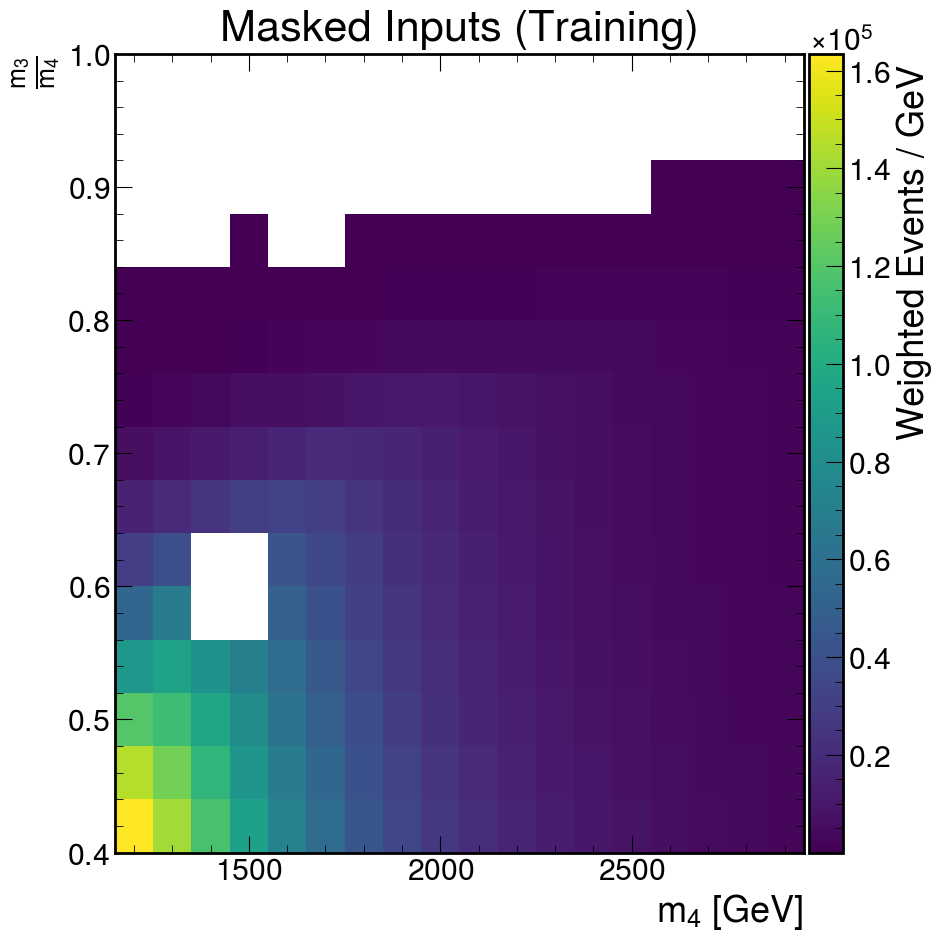

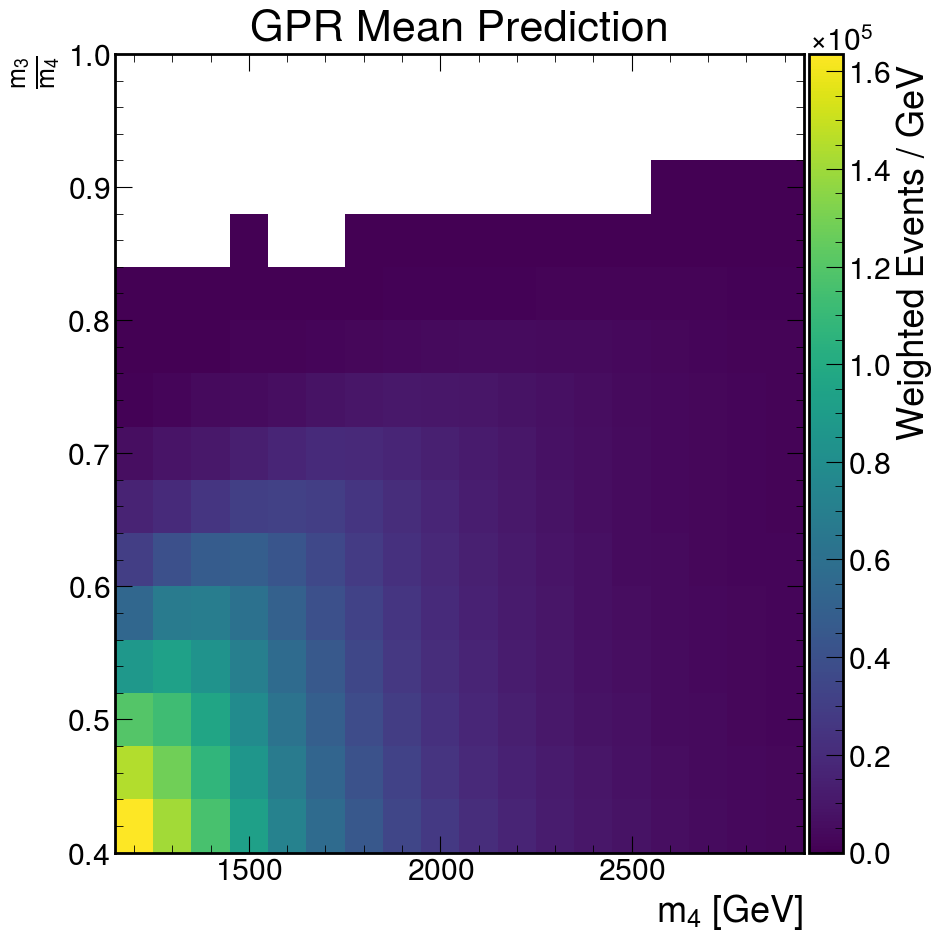

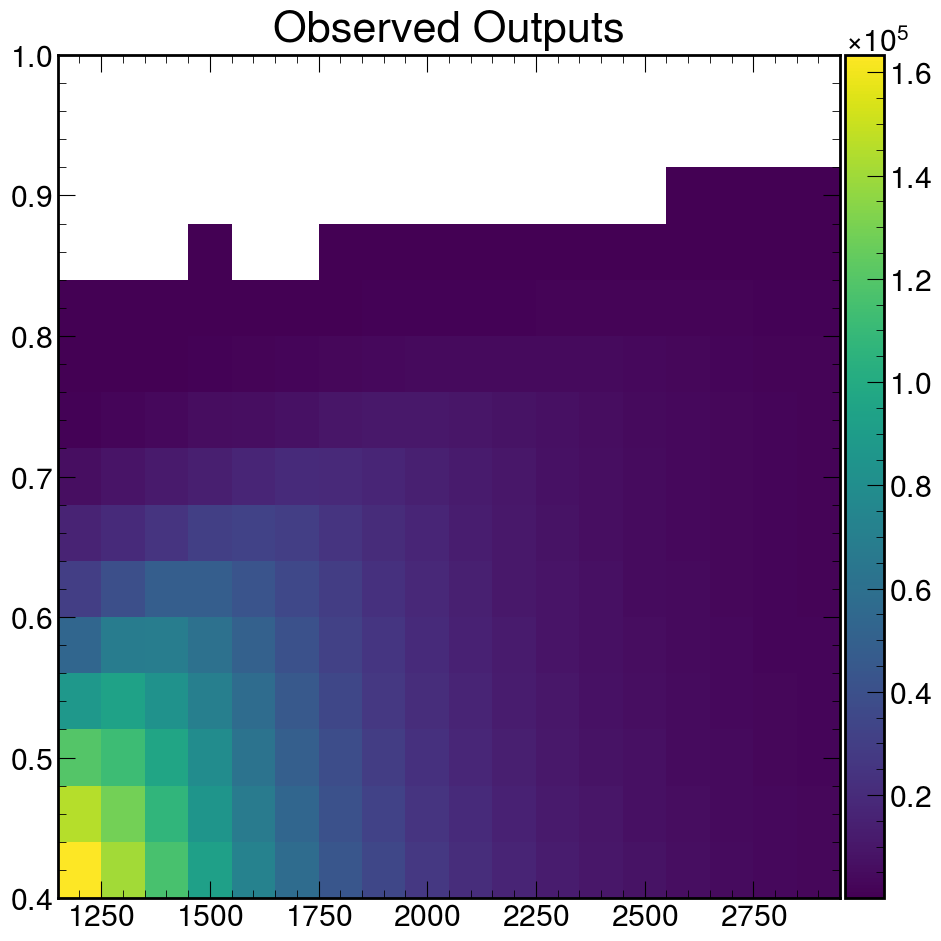

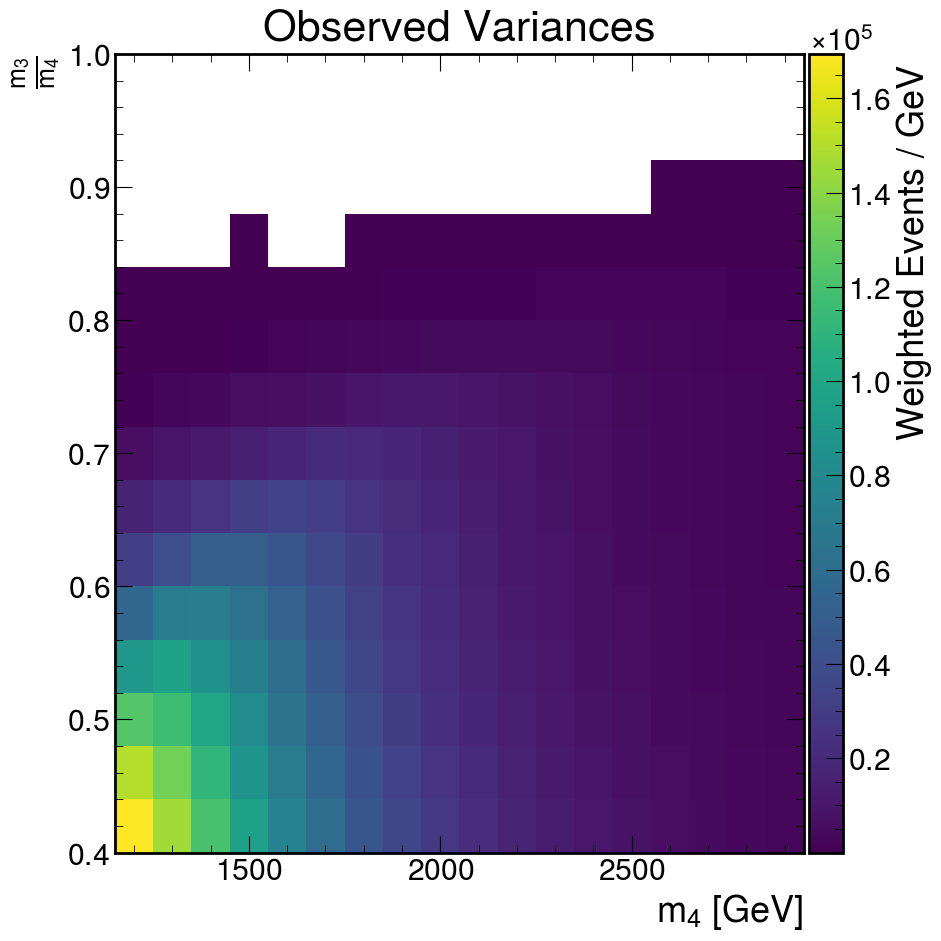

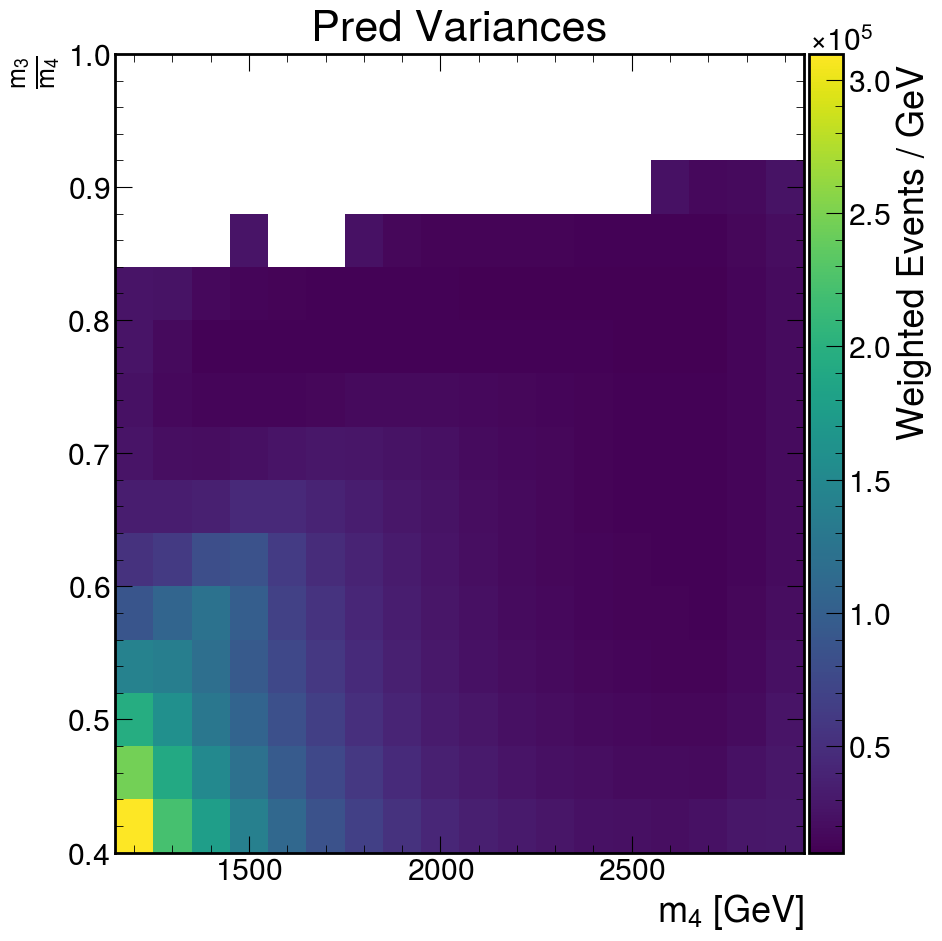

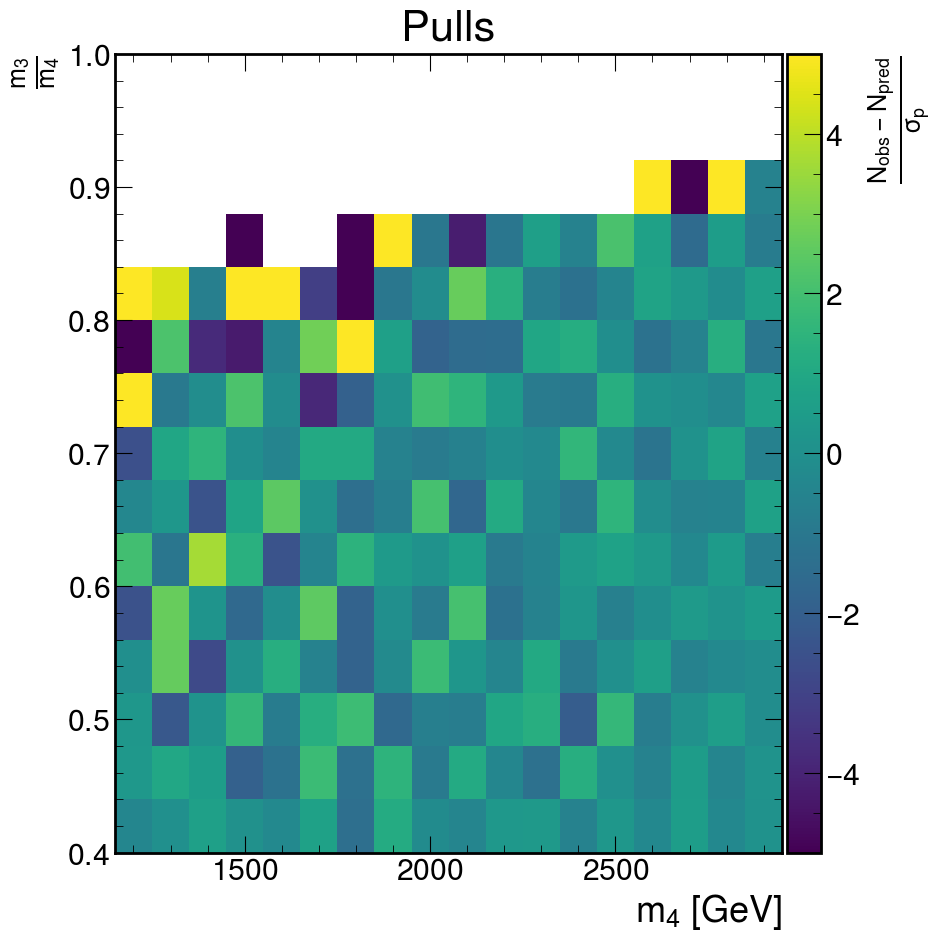

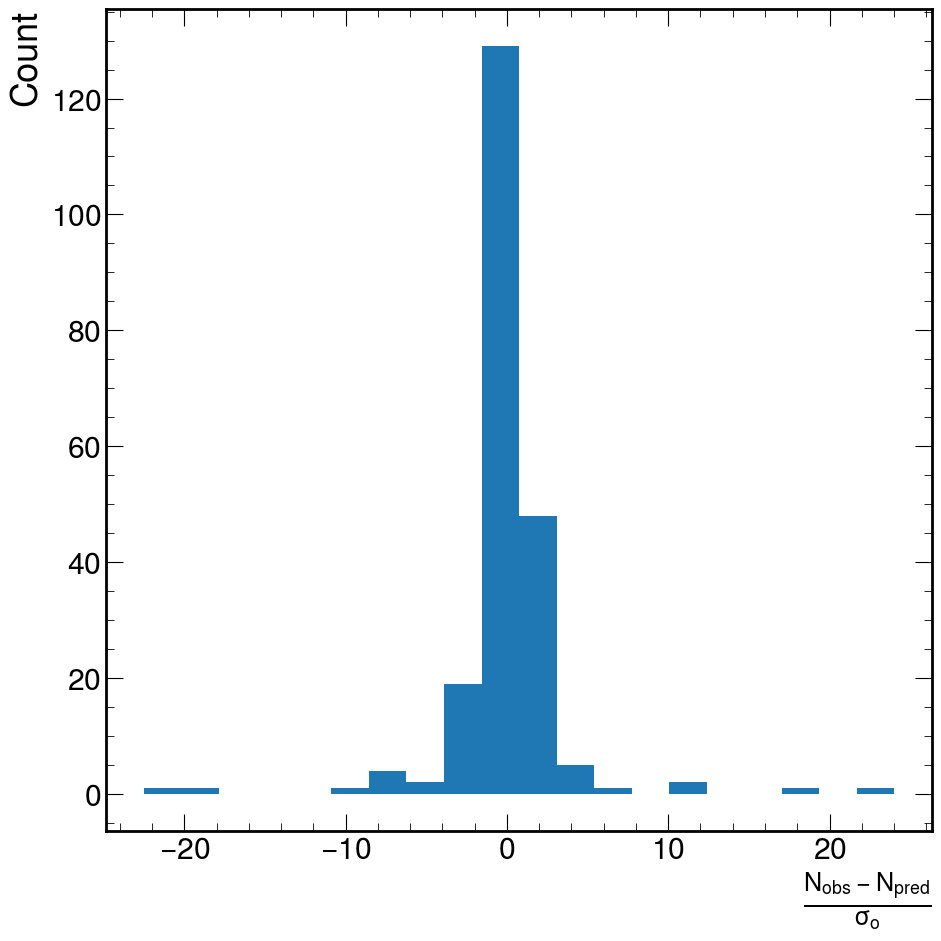

In [231]:
import linear_operator
with linear_operator.settings.max_cg_iterations(10000):
    pred = regression.getPrediction(model, likelihood, test)


from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools as it

pred_mean = pred.mean * value_scale
pred_var = pred.variance * value_scale ** 2


all_pulls = (pred_mean - raw_test.outputs) / torch.sqrt(raw_test.variances)
all_x2 = (pred_mean - raw_test.outputs)**2 / raw_test.variances
x2 = torch.sum(all_x2)

def addColorbar(ax, vals):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(vals, cax=cax)
    cax.get_yaxis().set_offset_position("left")
    ax.cax = cax

fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_train.inputs, raw_train.outputs)
ax.set_title("Masked Inputs (Training)")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))
fig.savefig(figpath / "training_points.pdf")

fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_test.inputs, pred_mean)
ax.set_title("GPR Mean Prediction")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))
fig.savefig(figpath / "gpr_mean.pdf")


fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_test.inputs, raw_test.outputs)
ax.set_title("Observed Outputs")
fig.savefig(figpath / "observed_outputs.pdf")



#drawAs2DHist(ax[1,1], PlotObject.fromHist(sig_hist))
#addTitles2D(ax[1,1], PlotObject.fromHist(sig_hist))
#ax[1,1].set_title("Signal MC")

fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_test.inputs, raw_test.variances)
ax.set_title("Observed Variances")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))

fig.savefig(figpath / "observed_variances.pdf")


fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_test.inputs, pred_var)
ax.set_title("Pred Variances")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))

fig.savefig(figpath / "predicted_variances.pdf")


fig, ax=plt.subplots(figsize=(10,10), layout="tight")
f = simpleGrid(ax, raw_test.edges, raw_test.inputs, (raw_test.outputs - pred_mean)/ torch.sqrt(raw_test.variances))
f.set_clim(-5,5)
ax.set_title("Pulls")
addTitles2D(ax, PlotObject.fromHist(qcd_hist))
ax.cax.set_ylabel(r"$\frac{N_{obs}-N_{pred}}{\sigma_{p}}$")
fig.savefig(figpath / "pulls.pdf")



import uhi
fig, ax=plt.subplots(figsize=(10,10), layout="tight")
p = PlotObject.fromHist(uhi.numpy_plottable.ensure_plottable_histogram(np.histogram(all_pulls[torch.abs(all_pulls) < np.inf], bins=20)))
drawAs1DHist(ax, p, yerr=False)
ax.set_xlabel(r"$\frac{N_{obs}-N_{pred}}{\sigma_{o}}$")
ax.set_ylabel("Count")
fig.savefig(figpath / "pulls_hist.pdf")

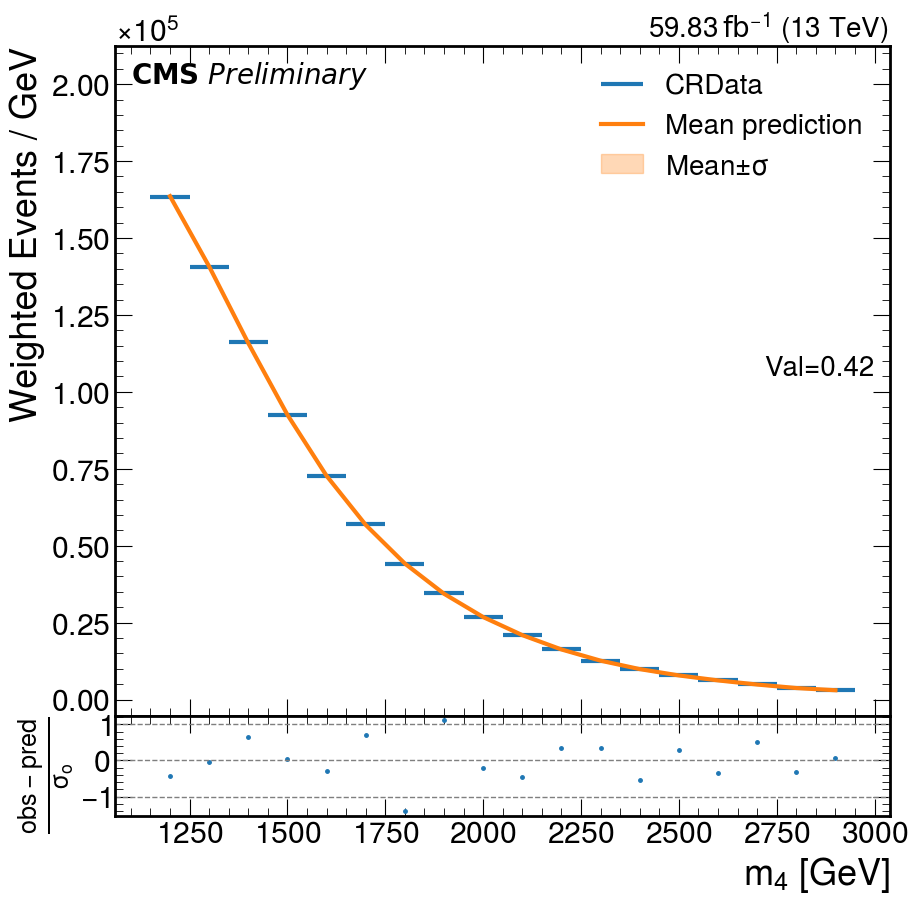

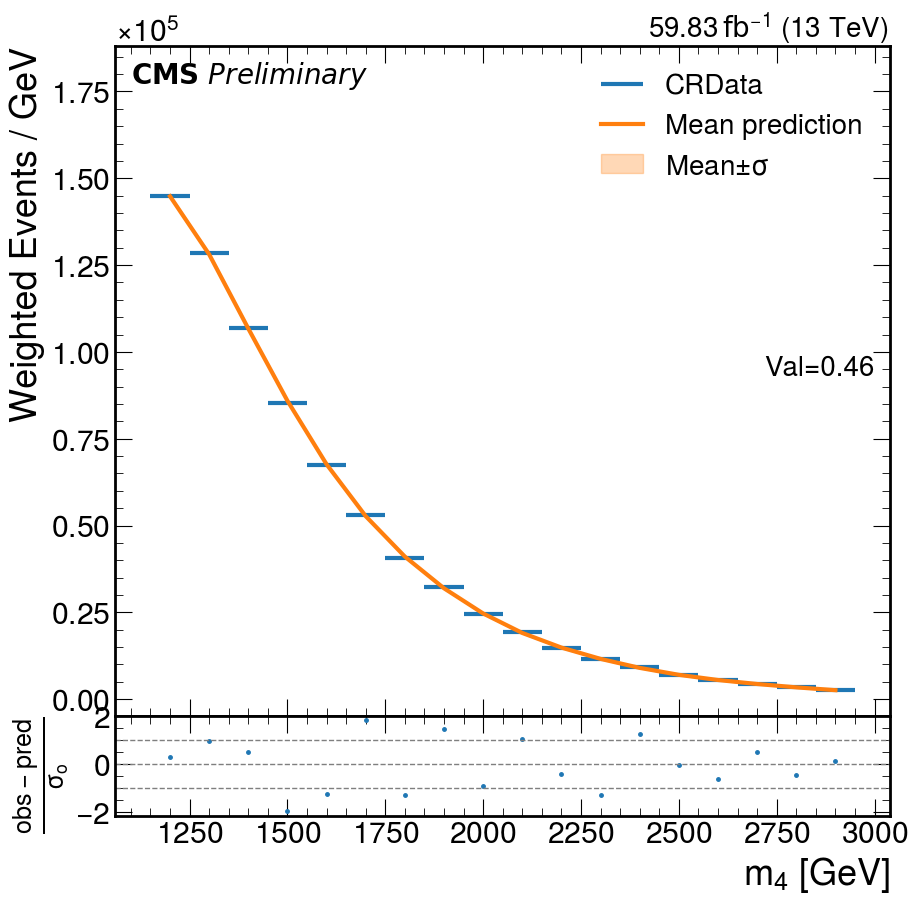

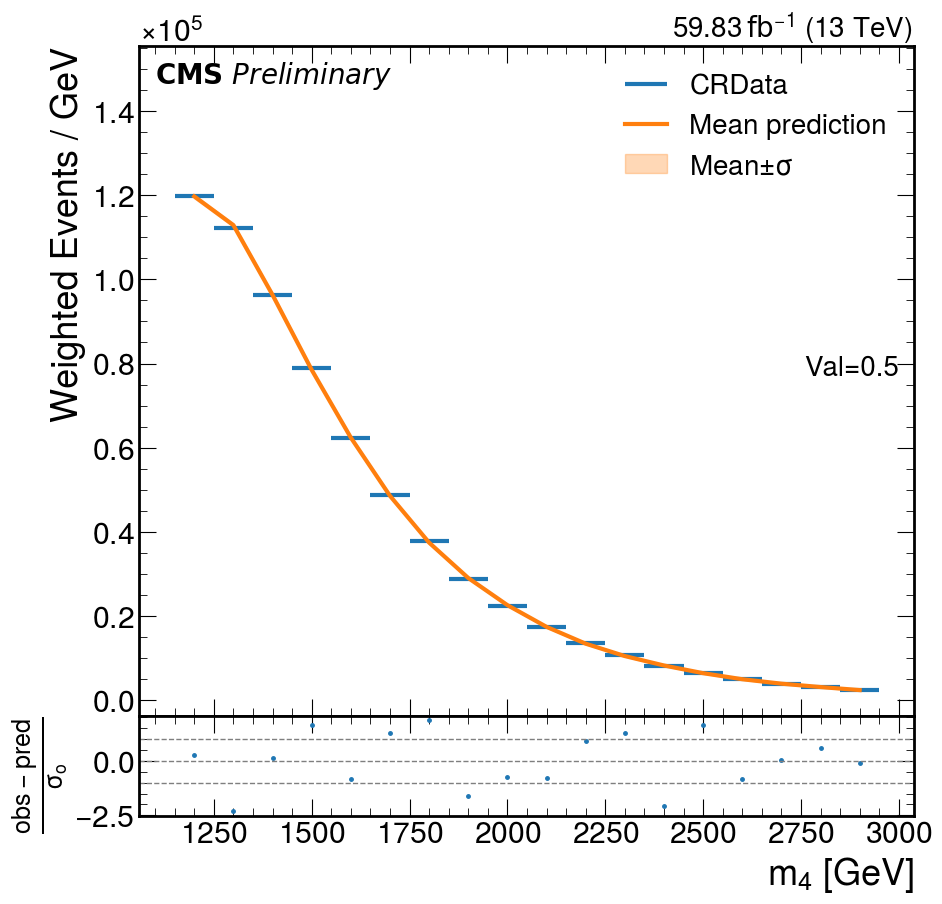

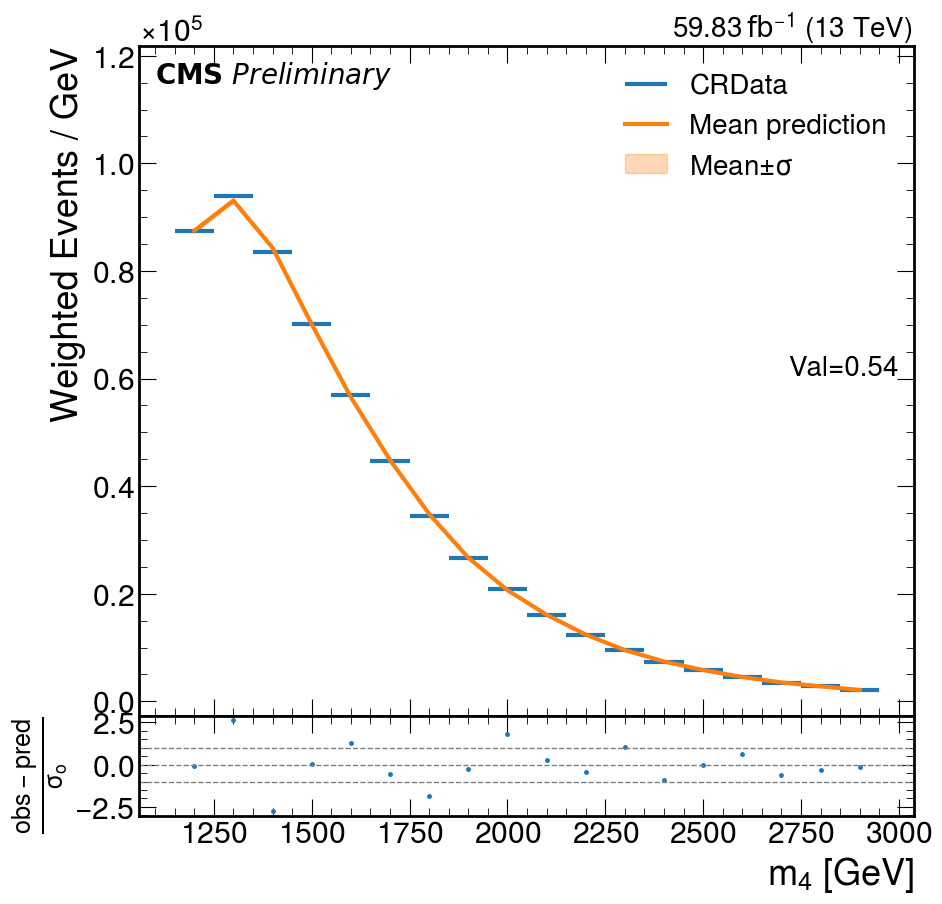

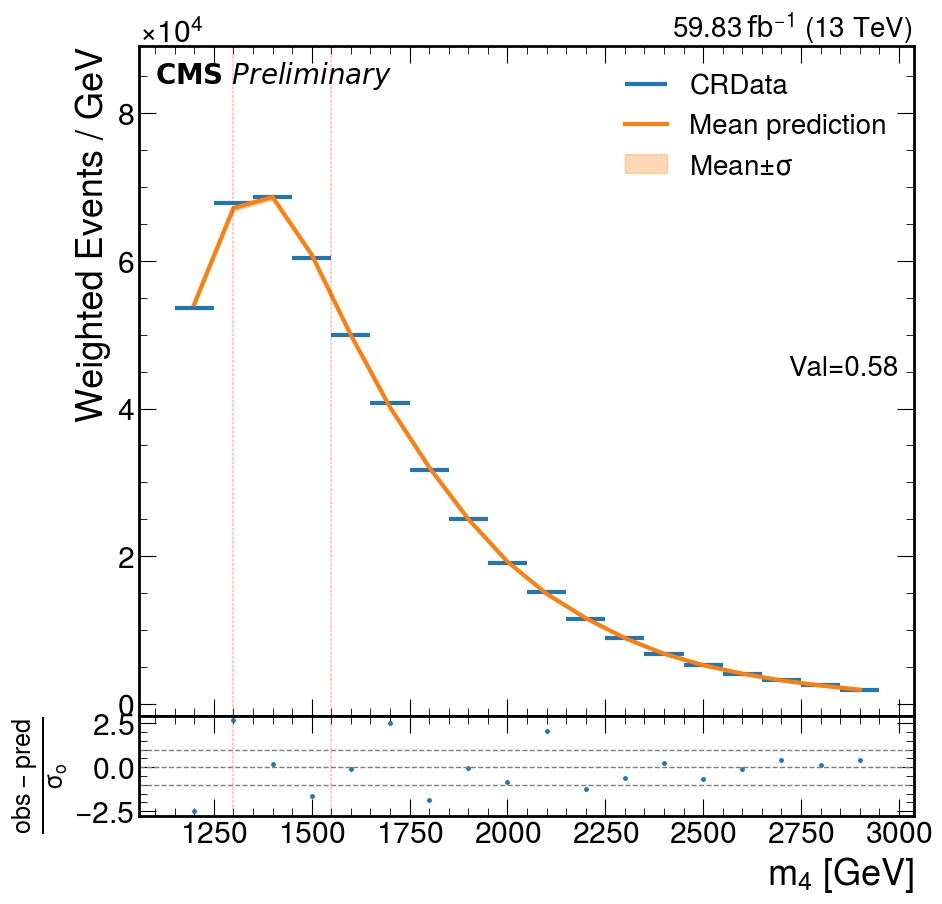

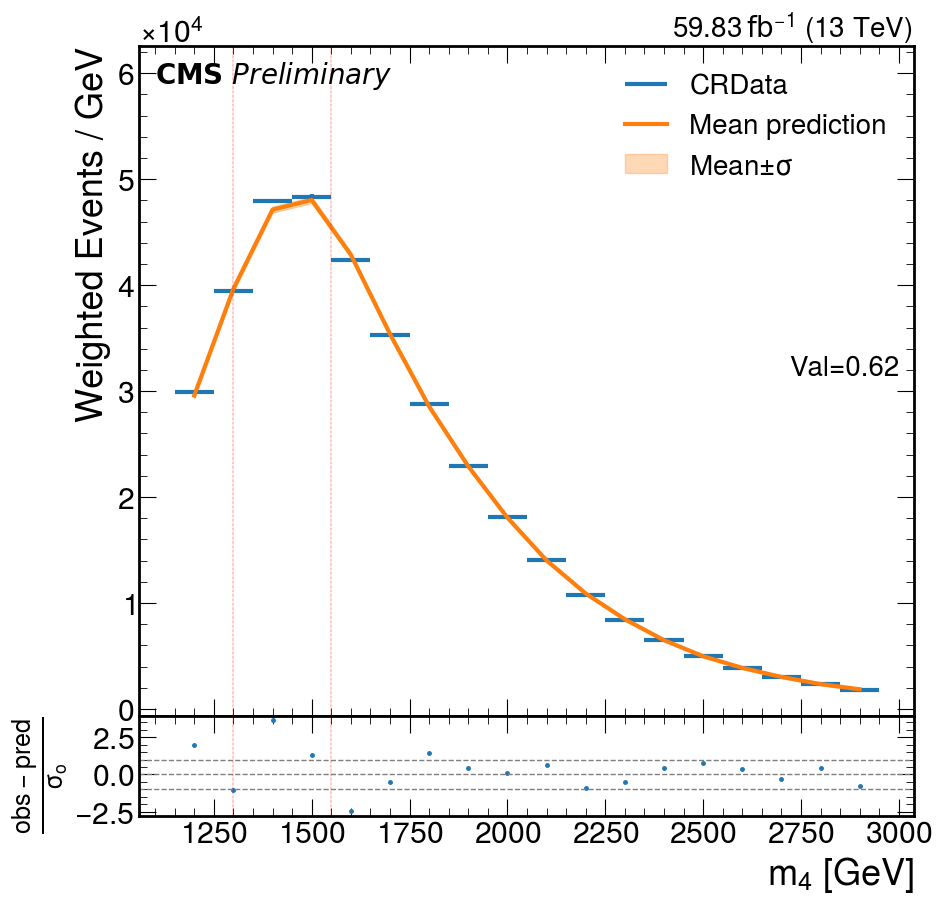

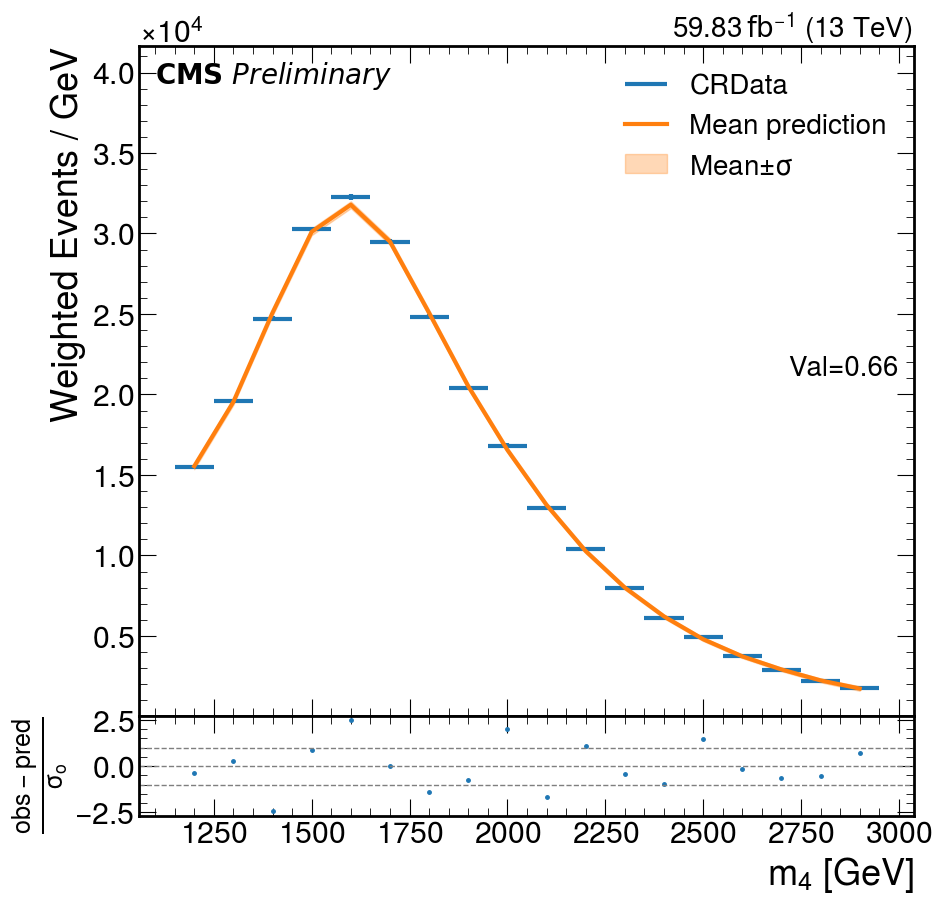

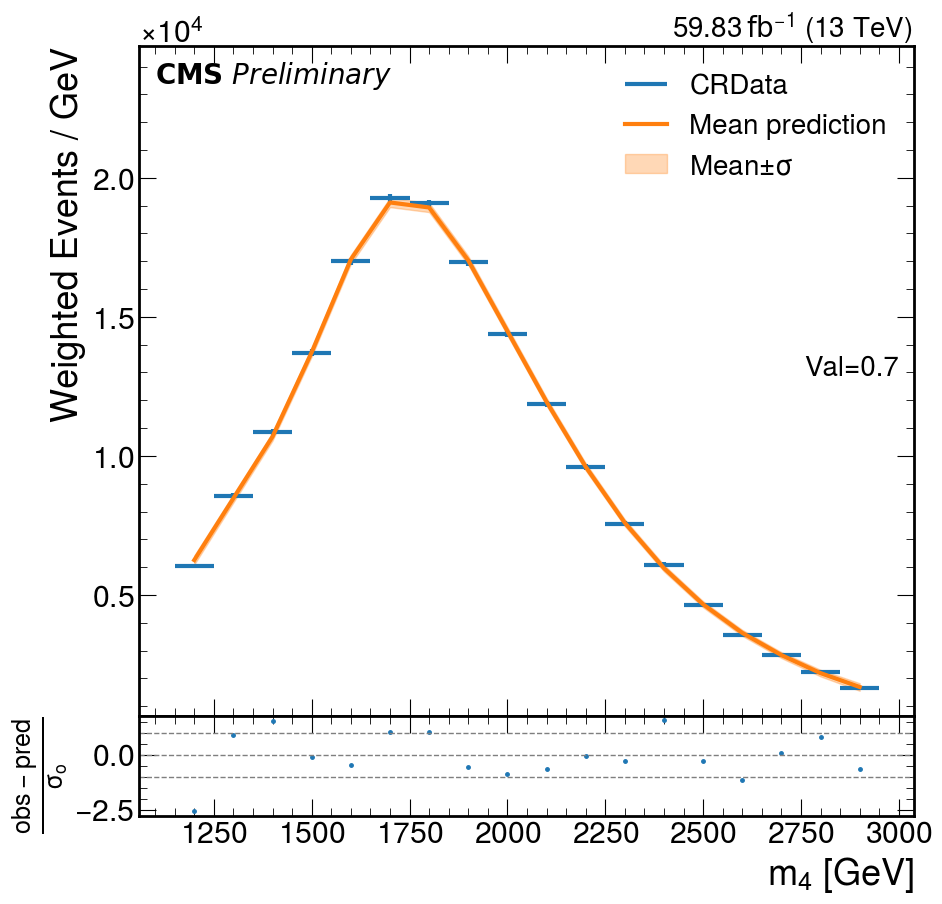

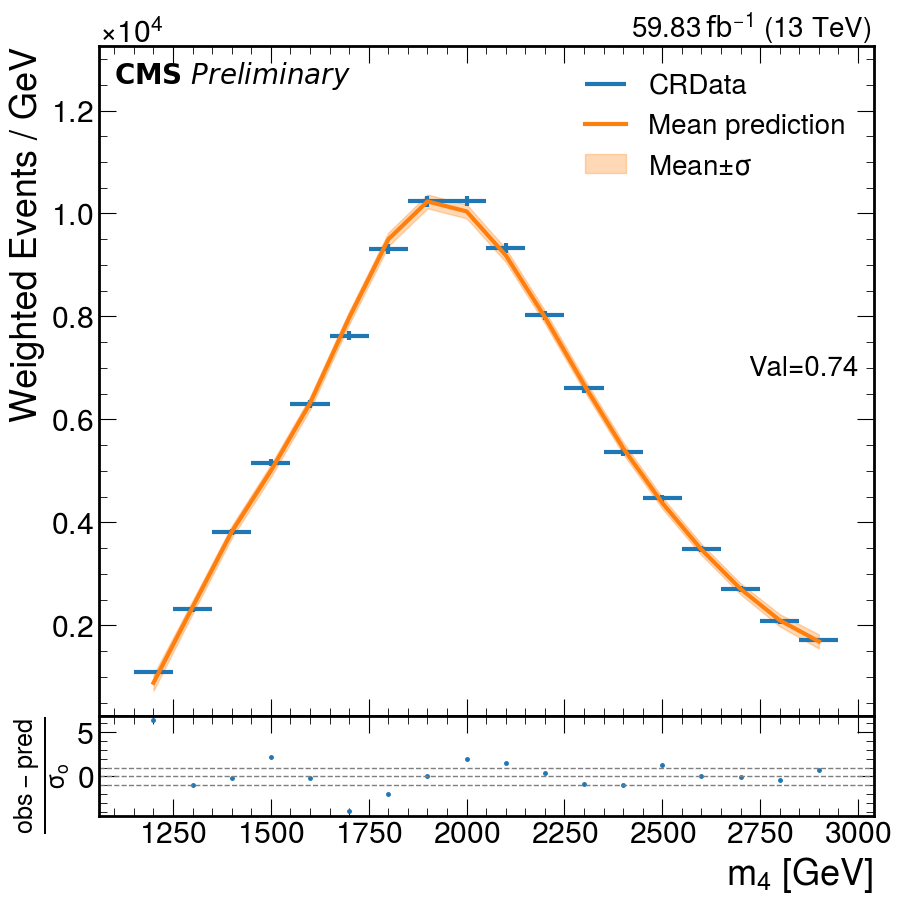

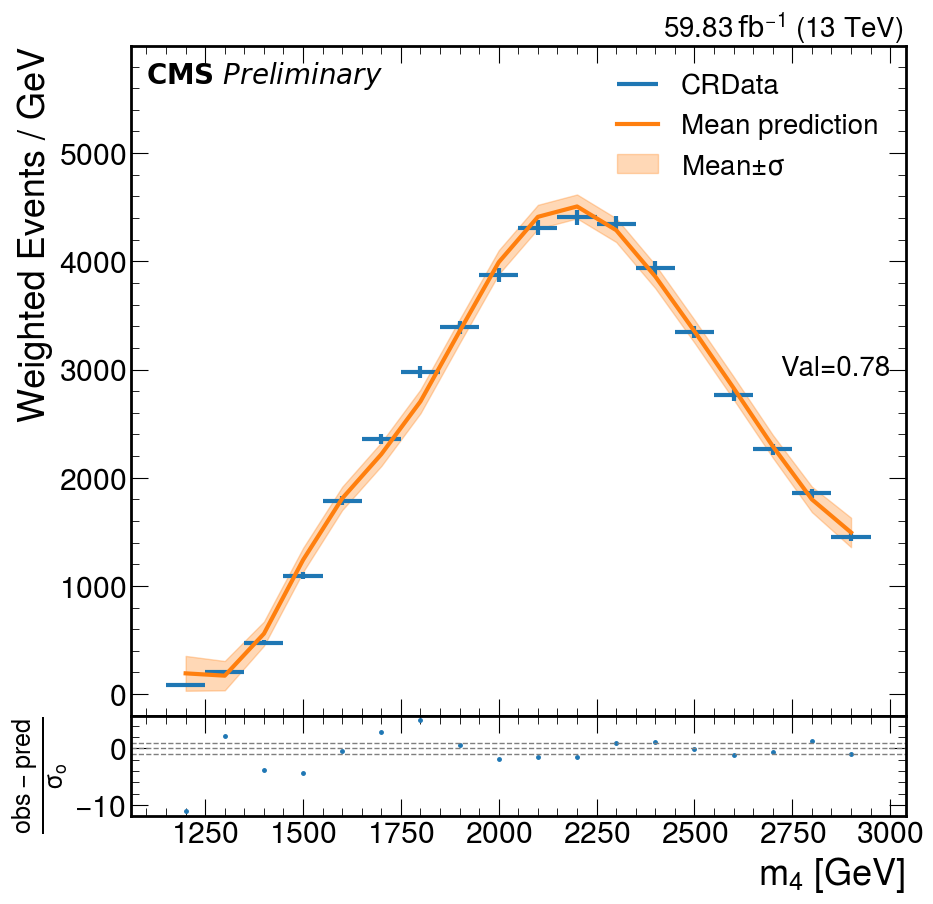

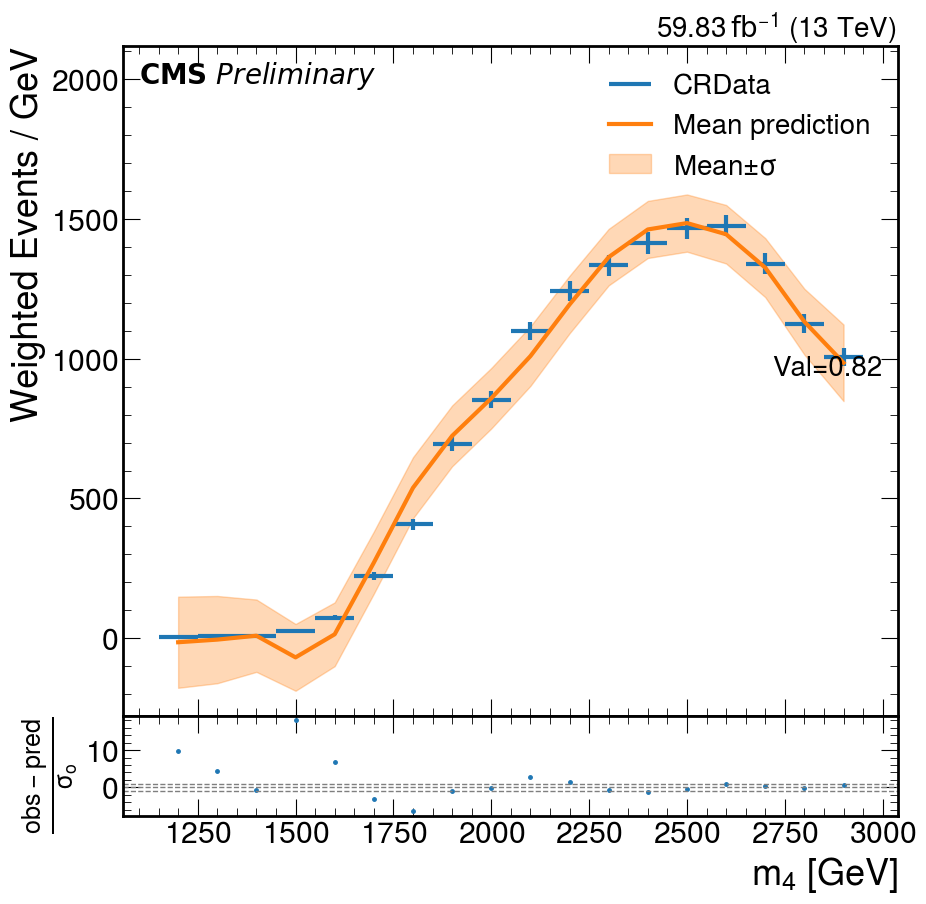

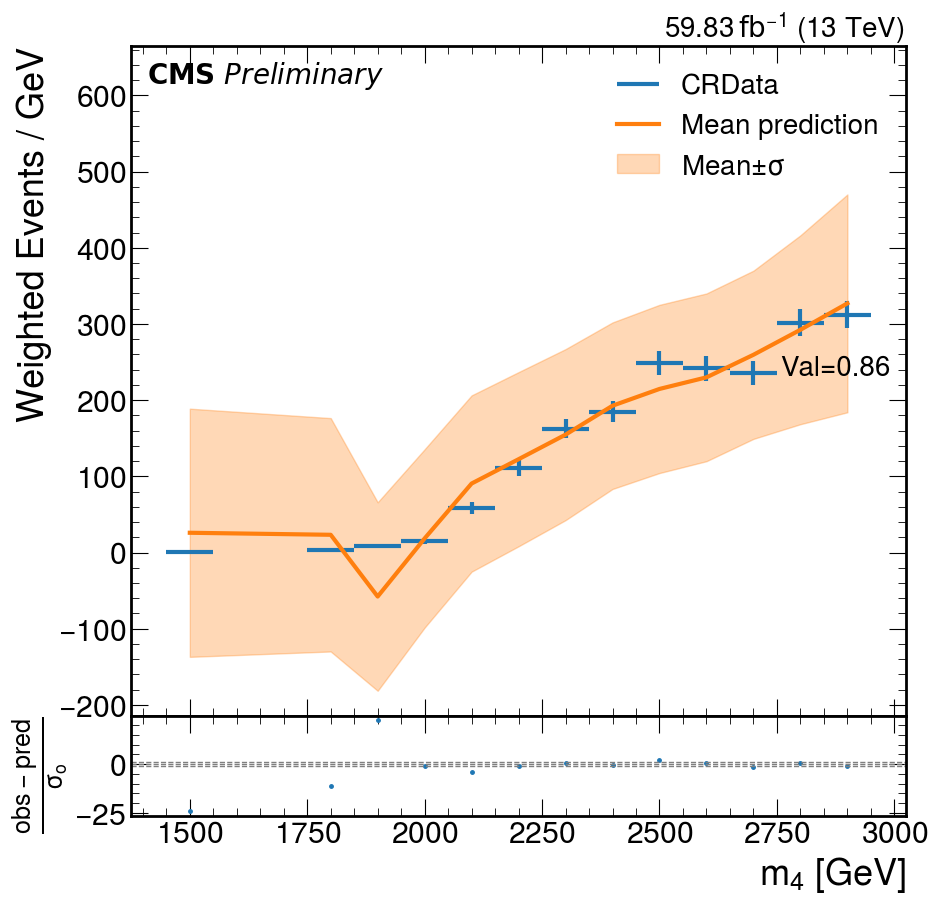

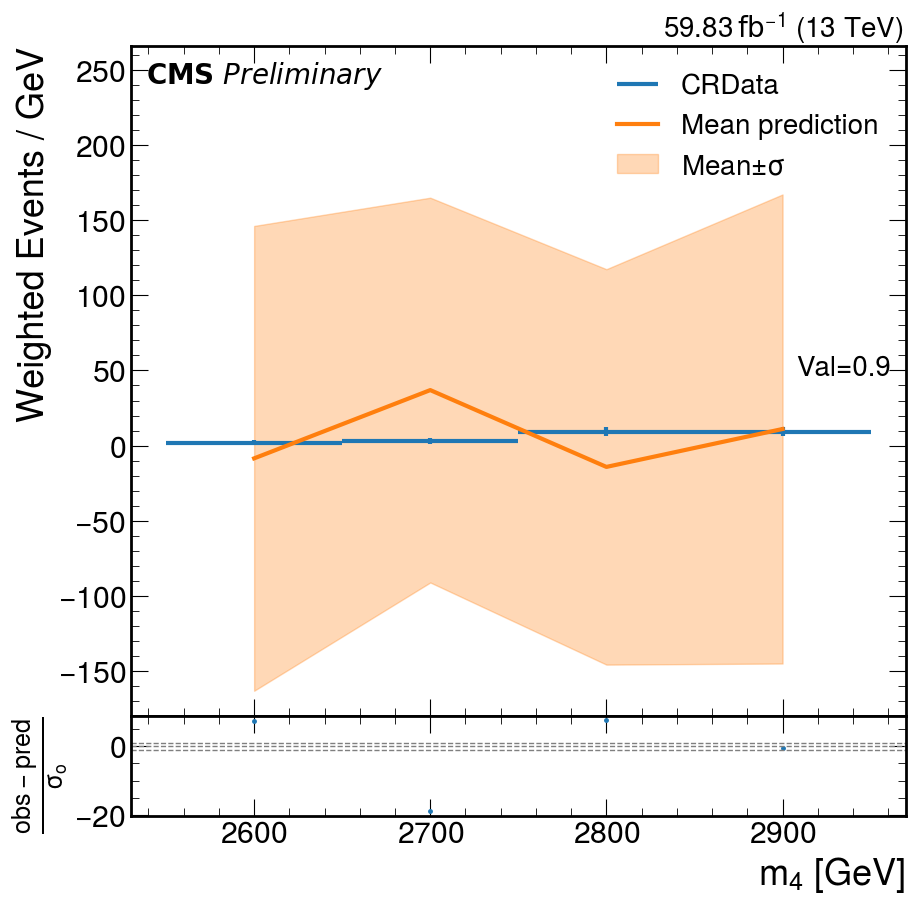

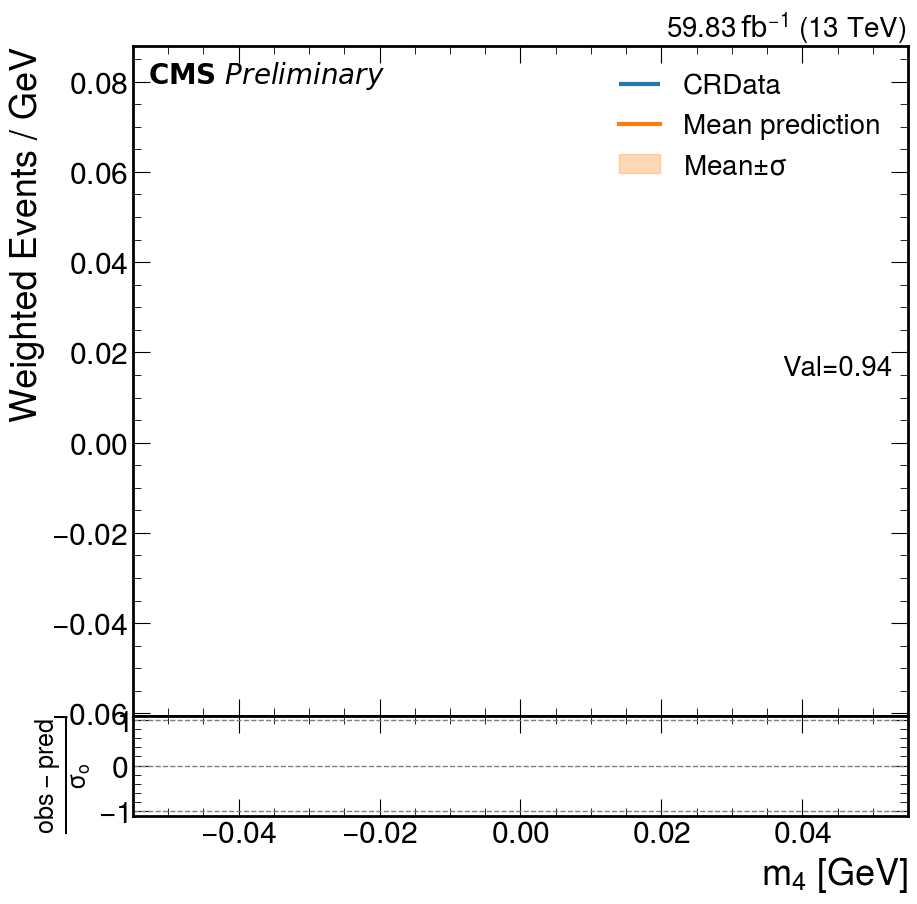

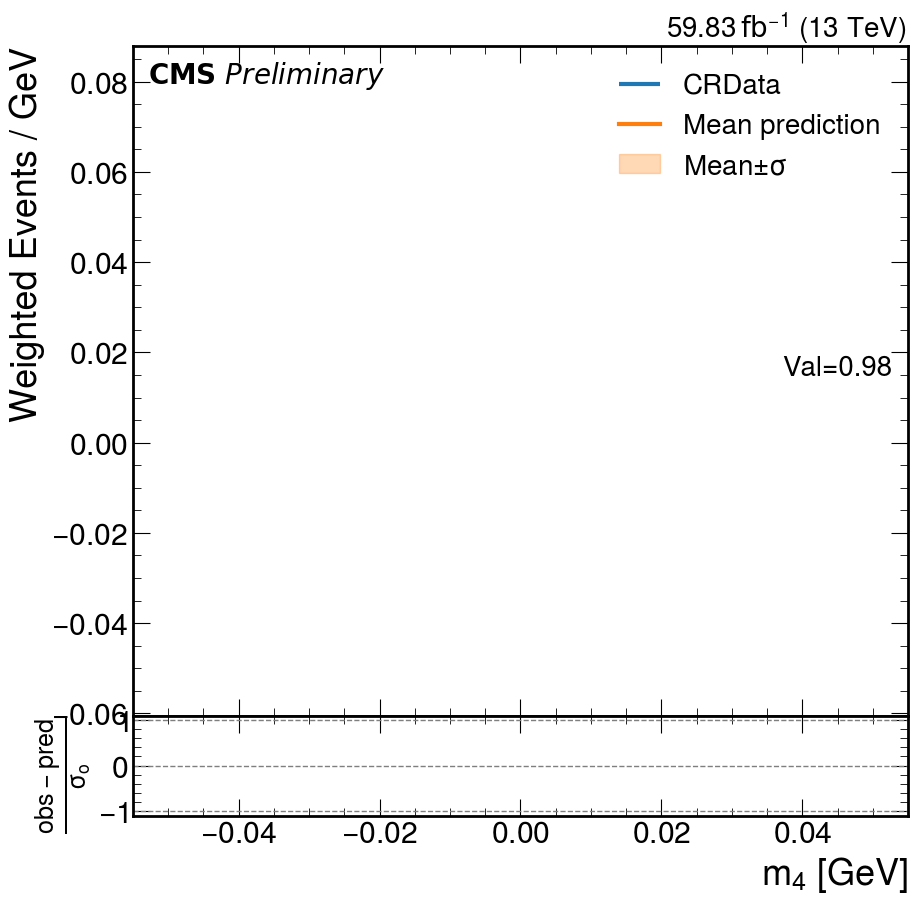

In [270]:
import fitting.plot_tools as fpt
import analyzer.plotting as plotting
from pathlib import Path
import importlib

importlib.reload(fpt)
dim = 1

pred_mean,_ = fitting.regression.pointsToGrid(raw_test.inputs, pred.mean * value_scale, raw_test.edges)
pred_var,_ = fitting.regression.pointsToGrid(raw_test.inputs, pred.variance*value_scale**2, raw_test.edges)
obs_vals,_ = fitting.regression.pointsToGrid(raw_test.inputs, raw_test.outputs, raw_test.edges)
obs_vars, filled = fitting.regression.pointsToGrid(raw_test.inputs, raw_test.variances, raw_test.edges)

(figpath /"slices" / f"along_{dim}").mkdir(parents=True, exist_ok=True)
for val, f, ax in fpt.createSlices(
    pred_mean.hist,
    pred_var.hist,
    obs_vals.hist,
    obs_vars.hist,
    raw_test.edges,
    filled,
    observed_title="CRData", window_2d=window, dim=dim):
    plotting.addTitles1D(ax, plotting.PlotObject.fromHist(qcd_hist[:,sum]))
    #f.savefig(figpath /"slices" / f"along_{dim}" /  (f"slice_{round(float(val),3)}".replace(".","p") + ".pdf"))
    #plt.close(f)
    
    